# NYC Taxi Data with TimescaleDB
### Data Engineering Capstone Project

##### ATTENTION: Before starting this project please make sure you have taken care of the dependencies described in the README file.

Location: ~/README.md


#### Project Summary
Let us imagine a New York City taxi company (The NYC Taxi and Limousine Commission (TLC)) wants to have a new BI system integrated that can answer a few questions about their business operations. The company has gathered data for years but never actually used it in a big scale.

Because all data we have are time-series, it is perfect to test an upgraded PostgreSQL database optimized for time-series. Maybe it could be the new heart of the company's new business intelligence infrastructure helping the in house data scientists to unlock more information faster then ever before. 

As data engineer we see our chance to bring value to the company.

The project follows the following steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up
* Step 6: Where to go from here...

### Step 1: Scope the Project and Gather Data

#### Scope 

To build a test version of the new system we will use only a part of the dataset from 2018 with around 12 GB.
We heard that time-series databases are best for our purposes because all we have is time-series data.

Our goal is it to answer questions like these:
- Is the weather having an effect on how many people are taking a taxi?
- Which hour of the has the most passengers?
- Can we use timescaleDB as back-end technology for data analytics apps like Shiny?

#### Describe and Gather Data 

- TLC Trip Record Data [CSV] (https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

- Brooklyn Bridge Automated Pedestrian Counts [JSON/API] (https://data.cityofnewyork.us/Transportation/Brooklyn-Bridge-Automated-Pedestrian-Counts-Demons/6fi9-q3ta)

Our yellow trip taxi records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. 

In additon to our companies data we also have heard of a project called the "Brooklyn Bridge Automated Pedestrian Counts" that not only includes hourly pedestrian counts crossing the bridge but is including holiday and weather data for New York City.

The companies data is in CSV format on our website and the Brooklyn Project data is available to us from the NYC Data API. (Please have a key, or use the JSON version we prepared for this)

In [2]:
#packages
import pandas as pd #for dataframes
import numpy as np #for datatype transformations
import configparser #for external configuration files
import psycopg2 #SDK for our timescaleDB

import datetime as dt
from IPython.display import Image #for the images in this file

import csv #for importing csv files
import requests #for downloading data
import json #for importing json files
from sodapy import Socrata #for using the API 

#### 1) Taxi Data IMPORT

In [56]:
#Importing the taxi_data

# TLC Data = taxi_data
taxi_data = pd.read_csv("data/out_2018_01.csv", 
                        parse_dates = ["tpep_pickup_datetime", "tpep_dropoff_datetime"])

taxi_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2018-01-01 00:21:05,2018-01-01 00:24:23,1.0,0.5,1.0,N,41.0,24.0,2.0,4.5,0.5,0.5,0.0,0.0,0.3,5.8
2,1.0,2018-01-01 00:44:55,2018-01-01 01:03:05,1.0,2.7,1.0,N,239.0,140.0,2.0,14.0,0.5,0.5,0.0,0.0,0.3,15.3
3,1.0,2018-01-01 00:08:26,2018-01-01 00:14:21,2.0,0.8,1.0,N,262.0,141.0,1.0,6.0,0.5,0.5,1.0,0.0,0.3,8.3
4,1.0,2018-01-01 00:20:22,2018-01-01 00:52:51,1.0,10.2,1.0,N,140.0,257.0,2.0,33.5,0.5,0.5,0.0,0.0,0.3,34.8


#### 2) Taxi Zone Data IMPORT

In [55]:
# Taxi Zone Data = taxi_zone_data
taxi_zone_data = pd.read_csv("data/taxi_zone_data.csv")
taxi_zone_data.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


#### 3) Bridge Data IMPORT

In [57]:
# Brooklin Bridege Data = bridge_data
bridge_data = pd.read_json("data/bridge_data.json")
bridge_data.head()

,hour_beginning,location,Pedestrians,Towards Manhattan,Towards Brooklyn,weather_summary,temperature,precipitation,lat,long,events,Location1
0,04/30/2019 12:00:00 AM,Brooklyn Bridge,3,3,0,,,,40.708164,-73.999509,,"(40.7081639691088, -73.9995087014816)"
1,04/01/2019 03:00:00 AM,Brooklyn Bridge,1,0,1,clear-night,36,0,40.708164,-73.999509,,"(40.7081639691088, -73.9995087014816)"
2,12/25/2019 02:00:00 PM,Brooklyn Bridge,3171,1685,1486,clear-day,44,0,40.708164,-73.999509,Christmas Day,"(40.7081639691088, -73.9995087014816)"
3,01/27/2019 09:00:00 PM,Brooklyn Bridge,13,5,8,partly-cloudy-night,41,0,40.708164,-73.999509,,"(40.7081639691088, -73.9995087014816)"
4,02/07/2019 04:00:00 AM,Brooklyn Bridge,0,0,0,cloudy,39,0,40.708164,-73.999509,,"(40.7081639691088, -73.9995087014816)"


### Step 2: Explore and Assess the Data
#### Explore the Data 

There are many ways to extract information for our project.
But a few tables that should be especially interesting are below.

###### taxi_data
- tpep_dropoff_datetime (as index for timescaleDB)
- fare_amount (for queries)
- tip_amount(for queries)
- trip_distance (for queries)

###### bridge_data
- hour_beginning (as index)
- pedestrians (for queries)
- events (for queries)
- temperature (for queries)
- precipitation (for queries)

###### zone_data
- location ids for better understanding where the taxi was (this could be extended with shapefile coordinates...)

#### Cleaning Steps
1. Check if the data has duplicates and drop accordingly 
2. Check if tables have NA and drop if all columns are NA (whole row? certain columns? drop or fill?) 
3. Check column types and change accordingly 
   - datetime (as timestamp) for time-series databases)
   - int for keys
   - numeric for numbers
   - text for certain objects
4. Check and change column names for better working flow


#### 1) Taxi Data CLEANING

In [17]:
#drop duplicates in the df
taxi_dup = taxi_data.drop_duplicates()

In [44]:
#drop na's in the df
taxi_clean = taxi_dup.dropna(how = "all")

In [46]:
taxi_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8759873 entries, 1 to 8776930
Data columns (total 17 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               float64       
 1   tpep_pickup_datetime   datetime64[ns]
 2   tpep_dropoff_datetime  datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             float64       
 6   store_and_fwd_flag     object        
 7   PULocationID           float64       
 8   DOLocationID           float64       
 9   payment_type           float64       
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
dtypes: datetime64[ns](2), float64(14), object(1)
memory usage: 1.2+ G

In [58]:
#change the column names for better management
taxi_clean.columns = ["vendor_id",
                      "pickup_datetime",
                      "dropoff_datetime",
                      "passenger_count",                      
                      "trip_distance",
                      "rate_code",
                      "store",
                      "pickup_id",
                      "dropoff_id",
                      "payment_type",
                      "fare_amount",
                      "extra",
                      "mta_tax",
                      "tip_amount",
                      "tolls_amount",
                      "improvement_surcharge",
                      "total_amount"]
taxi_clean.head(1)

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,rate_code,store,pickup_id,dropoff_id,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
1,1.0,2018-01-01 00:21:05,2018-01-01 00:24:23,1.0,0.5,1.0,N,41.0,24.0,2.0,4.5,0.5,0.5,0.0,0.0,0.3,5.8


In [52]:
#remove one column without need
taxi_df = taxi_clean.loc[ : , taxi_clean.columns != 'store'] 

In [93]:
#transform the df types accordingly
#will give a warning but should be fine
taxi_df['vendor_id'] = taxi_df['vendor_id'].apply(int)
taxi_df['rate_code'] = taxi_df['rate_code'].apply(int)
taxi_df['payment_type'] = taxi_df['payment_type'].apply(int)
taxi_df['pickup_id'] = taxi_df['pickup_id'].apply(int)
taxi_df['dropoff_id'] = taxi_df['dropoff_id'].apply(int)

<ipython-input-93-15e523644d87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_df['vendor_id'] = taxi_df['vendor_id'].apply(int)
<ipython-input-93-15e523644d87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  taxi_df['rate_code'] = taxi_df['rate_code'].apply(int)
<ipython-input-93-15e523644d87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

In [94]:
#final check
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8759873 entries, 1 to 8776930
Data columns (total 16 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   vendor_id              int64         
 1   pickup_datetime        datetime64[ns]
 2   dropoff_datetime       datetime64[ns]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   rate_code              int64         
 6   pickup_id              int64         
 7   dropoff_id             int64         
 8   payment_type           int64         
 9   fare_amount            float64       
 10  extra                  float64       
 11  mta_tax                float64       
 12  tip_amount             float64       
 13  tolls_amount           float64       
 14  improvement_surcharge  float64       
 15  total_amount           float64       
dtypes: datetime64[ns](2), float64(9), int64(5)
memory usage: 1.1 GB


#### 2) Taxi Zone Data CLEANING

In [59]:
taxi_zone_data.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [60]:
#drop duplicates in the df
taxi_zone_data_dup = taxi_zone_data.drop_duplicates()

In [61]:
#drop na's in the df
taxi_zones_clean = taxi_zone_data_dup.dropna(how = "all")

In [62]:
taxi_zones_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   LocationID    265 non-null    int64 
 1   Borough       265 non-null    object
 2   Zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.4+ KB


In [63]:
#change the column names for better management
taxi_zones_clean.columns = ["location_id",
                            "borough",
                            "zone",
                            "service_zone"]
zones_df = taxi_zones_clean

In [64]:
#final check
zones_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 264
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location_id   265 non-null    int64 
 1   borough       265 non-null    object
 2   zone          264 non-null    object
 3   service_zone  263 non-null    object
dtypes: int64(1), object(3)
memory usage: 10.4+ KB


#### 3) Bridge Data CLEANING

In [66]:
bridge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16057 entries, 0 to 16056
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   hour_beginning     16057 non-null  object 
 1   location           16057 non-null  object 
 2   Pedestrians        16057 non-null  int64  
 3   Towards Manhattan  16057 non-null  int64  
 4   Towards Brooklyn   16057 non-null  int64  
 5   weather_summary    16057 non-null  object 
 6   temperature        16057 non-null  object 
 7   precipitation      16057 non-null  object 
 8   lat                16057 non-null  float64
 9   long               16057 non-null  float64
 10  events             16057 non-null  object 
 11  Location1          16057 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 1.5+ MB


In [70]:
#first cut down on interesting columns
bridge_selection = bridge_data[["hour_beginning", "Pedestrians", "weather_summary", "temperature", "precipitation", "events"]]
bridge_selection.head()

,hour_beginning,Pedestrians,weather_summary,temperature,precipitation,events
0,04/30/2019 12:00:00 AM,3,,,,
1,04/01/2019 03:00:00 AM,1,clear-night,36,0,
2,12/25/2019 02:00:00 PM,3171,clear-day,44,0,Christmas Day
3,01/27/2019 09:00:00 PM,13,partly-cloudy-night,41,0,
4,02/07/2019 04:00:00 AM,0,cloudy,39,0,


In [71]:
#drop duplicates in the df
bridge_dup = bridge_selection.drop_duplicates()

In [105]:
#drop na's in the df
bridge_clean = bridge_dup.dropna(how = "all")

In [106]:
#change the column names for better management
bridge_clean.columns = ["datetime",
                        "pedestrians",
                        "weather",
                        "temperature",
                        "rain",
                        "events"]
bridge_df = bridge_clean
bridge_df.head()

,datetime,pedestrians,weather,temperature,rain,events
0,04/30/2019 12:00:00 AM,3,,,,
1,04/01/2019 03:00:00 AM,1,clear-night,36,0,
2,12/25/2019 02:00:00 PM,3171,clear-day,44,0,Christmas Day
3,01/27/2019 09:00:00 PM,13,partly-cloudy-night,41,0,
4,02/07/2019 04:00:00 AM,0,cloudy,39,0,


In [107]:
bridge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16057 entries, 0 to 16056
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   datetime     16057 non-null  object
 1   pedestrians  16057 non-null  int64 
 2   weather      16057 non-null  object
 3   temperature  16057 non-null  object
 4   rain         16057 non-null  object
 5   events       16057 non-null  object
dtypes: int64(1), object(5)
memory usage: 878.1+ KB


In [108]:
#transform the df types accordingly
bridge_df["datetime"] = pd.to_datetime(bridge_df["datetime"])
bridge_df["temperature"] = pd.to_numeric(bridge_df["temperature"])
bridge_df["rain"] = pd.to_numeric(bridge_df["rain"])

In [109]:
#last check
bridge_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16057 entries, 0 to 16056
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   datetime     16057 non-null  datetime64[ns]
 1   pedestrians  16057 non-null  int64         
 2   weather      16057 non-null  object        
 3   temperature  16041 non-null  float64       
 4   rain         16041 non-null  float64       
 5   events       16057 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 878.1+ KB


In [110]:
bridge_df.head()

,datetime,pedestrians,weather,temperature,rain,events
0,2019-04-30 00:00:00,3,,NaN,NaN,
1,2019-04-01 03:00:00,1,clear-night,36.0,0.0,
2,2019-12-25 14:00:00,3171,clear-day,44.0,0.0,Christmas Day
3,2019-01-27 21:00:00,13,partly-cloudy-night,41.0,0.0,
4,2019-02-07 04:00:00,0,cloudy,39.0,0.0,


In [112]:
#fill NaN for NUMERIC values
bridge_df["temperature"] = bridge_df["temperature"].fillna(0)
bridge_df["rain"] = bridge_df["rain"].fillna(0)
bridge_df["pedestrians"] = bridge_df["pedestrians"].fillna(0)

In [113]:
bridge_df.head()

,datetime,pedestrians,weather,temperature,rain,events
0,2019-04-30 00:00:00,3,,0.0,0.0,
1,2019-04-01 03:00:00,1,clear-night,36.0,0.0,
2,2019-12-25 14:00:00,3171,clear-day,44.0,0.0,Christmas Day
3,2019-01-27 21:00:00,13,partly-cloudy-night,41.0,0.0,
4,2019-02-07 04:00:00,0,cloudy,39.0,0.0,


### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model


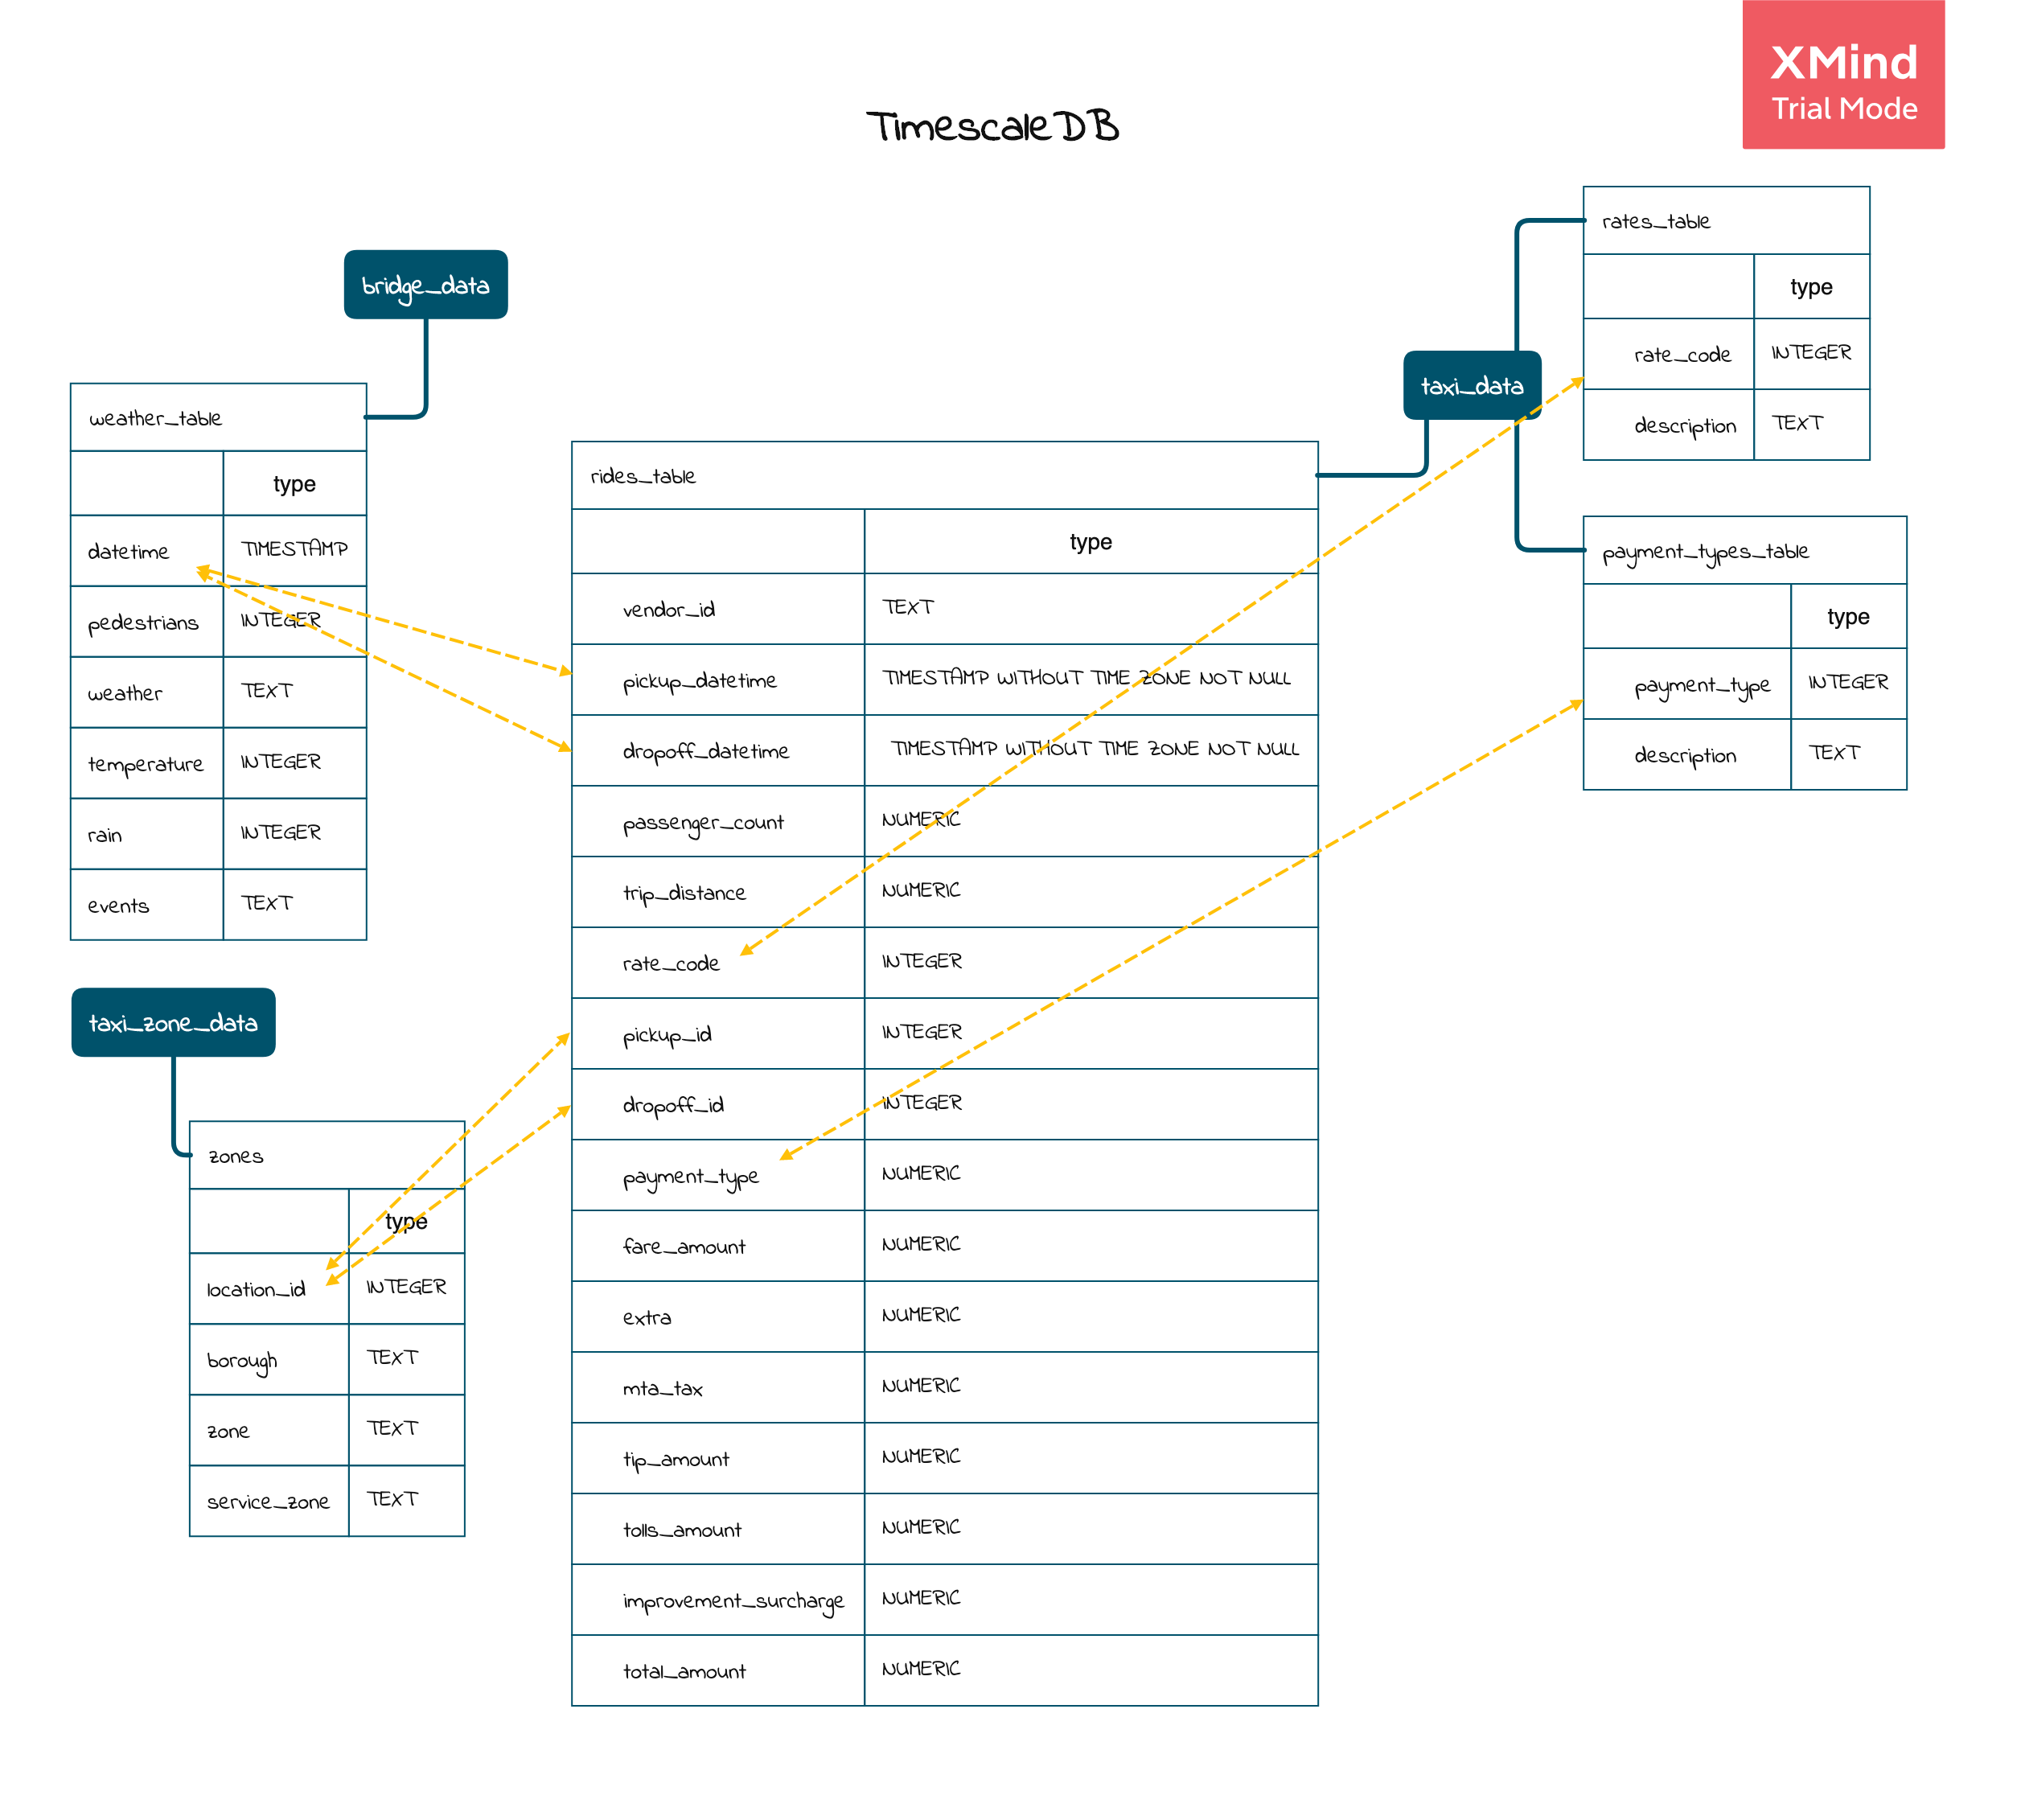

In [86]:
Image(filename="man/data_model.png")

#### 3.2 Mapping Out Data Pipelines
I will use a few scripts for the datapipeline:

##### 1. "download_api_bridge_data.py" & "download_csv_taxi_data.py"
These scripts will download the full data needed for the project if not using sample data for testing.

Location: ~/data/full_data

##### 2. "prepare_data.py
This script will use the data cleaning steps above and write the results into staging files in the ~/data/staging_data files.

Location: ~/

#### 3. "create_tables.py
This script will create the tables in the database on TimescaleDB server.

Using: sql_queries.py & dwh.cfg
Location: ~/

#### 4. "sql_queries.py
This script will hold all the queries needed for the etl and create_tables scripts.

Location: ~/

#### 5. "etl.py"
This script will do the heavy lifing and copy the data into the data base.

Location: ~/

### Step 4: Run Pipelines to Model the Data 
#### 4.0 The Data Model Tables
Below you can find all the tables that are drawn above in the data model overview.
The extension timescaleDB is takes care of the primary key when creating a hypertable. (in this case pickup_datetime will be the hypertables primary key) See below for how to run the pipeline scripts.

The rides table is our 'main' table in the data model.

In [ ]:
#DO NOT RUN
#rides
CREATE TABLE rides
(
    vendor_id INTEGER,
    pickup_datetime TIMESTAMP WITHOUT TIME ZONE NOT NULL,
    dropoff_datetime TIMESTAMP WITHOUT TIME ZONE NOT NULL,
    passenger_count NUMERIC,
    trip_distance NUMERIC,
    pickup_id  INTEGER,
    rate_code  INTEGER,
    dropoff_id INTEGER,
    payment_type INTEGER,
    fare_amount NUMERIC,
    extra NUMERIC,
    mta_tax NUMERIC,
    tip_amount NUMERIC,
    tolls_amount NUMERIC,
    improvement_surcharge NUMERIC,
    total_amount NUMERIC
);
SELECT create_hypertable('rides', 'pickup_datetime', 'payment_type', 2, create_default_indexes=>FALSE);
CREATE INDEX ON rides (vendor_id, pickup_datetime desc);
CREATE INDEX ON rides (pickup_datetime desc, vendor_id);
CREATE INDEX ON rides (rate_code, pickup_datetime DESC);
CREATE INDEX ON rides (passenger_count, pickup_datetime desc);

The payment_type table will deliver more details.

In [ ]:
#payment_types
CREATE TABLE payment_types
(
    payment_type INTEGER,
    description TEXT
);

The rates table will deliver more details.

In [ ]:
#rates
CREATE TABLE rates
(
    rate_code   INTEGER,
    description TEXT
);

The weather table can also transformed into a hypertable for better key management.

In [ ]:
#weather
CREATE TABLE weather
(
    datetime TIMESTAMP WITHOUT TIME ZONE NOT NULL,
    pedestrians INTEGER,
    weather TEXT,
    temperature NUMERIC,
    rain NUMERIC,
    events TEXT
);

The zones table will deliver more information about the zones. Could be extended into coordinates with shape files.

In [ ]:
#zones
CREATE TABLE zones
(
    location_id INTEGER,
    borough TEXT,
    zone TEXT,
    service_zone TEXT
);

The taxi_hour table is an customized analytics table using an aggregate of datetime (=hourly) to fit to the weather table. 

In [ ]:
#taxi_hour
CREATE TABLE taxi_hour
(
one_hour TIMESTAMP WITHOUT TIME ZONE NOT NULL,
count_rides NUMERIC
);
SELECT create_hypertable('taxi_hour', 'one_hour');

#### 4.1 How to run the pipeline

(For these steps we can just use the provide sample data for January 2018, no need for the full dataset to save time and resources)

In [ ]:
#first we can prepare the staging data
%run -i prepare_data.py

In [ ]:
#then we can do a quick data check
%run -i check_data.py

In [ ]:
#next we can create the tables based on the model above
%run -i create_tables.py

In [ ]:
#finally we can run the etl
%run -i etl.py

#### 4.2 Data Quality Checks

#### Quality Check - Staging Data Check
To make sure that the data going into the database has been created (in the staging_data file) accordingly, I have created a script that will check the three data sources that will go into different tables. 
Checked will be the row and column amount of the data. If it runs successfull there should not be a problem with the data.

In [14]:
%run -i data_check.py

Data quality in: data/staging_data/bridge_df.csv - Check PASSED.
(rows, colums)
(16056, 6)
Data quality in: data/staging_data/taxi_df.csv - Check PASSED.
(rows, colums)
(8759872, 16)
Data quality in: data/staging_data/zones_df.csv - Check PASSED.
(rows, colums)
(264, 4)


#### Quality Check - Testing Query
To check not only the data but also the infrastructure on timescaleDB, I have created an additional table "taxi_hour" that will be used for a special query only possible in TimescaleDB.
The table will be created after all the other tables are in place and ready to be queried (in the etl.py script).
It will take one month of data from the "rides" table and then aggregate the date to hourly blocks.
Then we can join it with the weather table (which datetime column has hourly data points natively).
With this query we can check if the database is working as thought, using the power of timescaleDB.

###### checking the "taxi_hour table"

In [83]:
#configurations
config = configparser.ConfigParser()
config.read('dwh.cfg')
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['TIMESCALEDB'].values()))

#open connection
cur = conn.cursor()

#queries
query = ("""
SELECT one_hour, count_rides
FROM taxi_hour
LIMIT 5;
""")

#get the data & close again
cur.execute(query)
data = cur.fetchall()
cur.close()

#data to dataframe
column_names = ["one_hour", "count_rides"]
df = pd.DataFrame(data, columns=column_names)
print(df)

             one_hour count_rides
0 2018-01-01 00:00:00       16457
1 2018-01-01 01:00:00       18985
2 2018-01-01 02:00:00       16561
3 2018-01-01 03:00:00       12611
4 2018-01-01 04:00:00        8726


The resulting table should show us that we have a fresh table with aggregated data from the original 'rides' table.

#### checking the join of "taxi_hour" & "weather" table

In [85]:
#configurations
config = configparser.ConfigParser()
config.read('dwh.cfg')
conn = psycopg2.connect("host={} dbname={} user={} password={} port={}".format(*config['TIMESCALEDB'].values()))

#open connection
cur = conn.cursor()

#queries
query = ("""
SELECT one_hour, count_rides, weather.rain, weather.weather, weather.temperature
FROM taxi_hour
JOIN weather ON taxi_hour.one_hour = weather.datetime
GROUP BY one_hour, count_rides, weather.rain, weather.weather, weather.temperature
ORDER BY one_hour
LIMIT 5;
""")

#get the data & close again
cur.execute(query)
data = cur.fetchall()
cur.close()

#data to dataframe
column_names = ["one_hour", "count_rides", "rain", "weather", "temperature"]
df = pd.DataFrame(data, columns=column_names)
print(df)

             one_hour count_rides rain      weather temperature
0 2018-01-01 00:00:00       16457  0.0  clear-night         9.0
1 2018-01-01 01:00:00       18985  0.0  clear-night         8.0
2 2018-01-01 02:00:00       16561  0.0  clear-night         8.0
3 2018-01-01 03:00:00       12611  0.0  clear-night         7.0
4 2018-01-01 04:00:00        8726  0.0  clear-night         7.0


The resulting table should show us that we have successfully joined the 'weather' and the 'taxi_hour' table.
This kind of query could be used for analytics on how the weather would influence taxi usage in the city.

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

Location: ~/data/data_dictionaries

#### Step 5: Project Write Up


#### Technology Choice

1. TimescaleDB

As data scientist in the financial sector I have been working with mostly time-series data. Although it is possible to use standard SQL and NoSQL database solutions for this kind of data, a more specialized type, called time-series databases have many advantages over traditional solutions such as PostgreSQL or Cassandra.

I chose Timescale's TimescaleDB to have both the speed of NoSQL and ability to query as with SQL DB solutions.
TimescaleDB is build as an extension on top of PostgreSQL and thus easy to learn.
The most important function for me, however is the ability to aggregate datetime data (as primary key).
With this function no more further transformation in R or Python is needed. The DB does this much faster and much more convinient.

2. AWS EC2

Because Redshift clusters do not provide TimescaleDB as DB option we need to build my own infrastructure.
Our project is quite small and easy to set up, though. The AWS-CLI will let us setup our DB server in seconds.


#### Updating the Data

Assuming new data would be available on a regular basis (Covid-19 makes it difficult) a daily/weekly/monthly update of the data could be possible. I used only 2018 data for this project, because 2019/2020 data is affected by Covid-19 and thus not fully available for all dataset choices.


#### Scenarios
##### 1. Data Size (The data was increased by 100x)

When the data increases by 100x then the only variable in this infrastructure that should be changed is the EC2 instance where the TimescaleDB is running. The database itself can ajdust automatically to the server it is using.
When there is better hardware available (through an upgrade) the database can be 'tuned' through a function called timescale-tune. (More here: https://blog.timescale.com/blog/better-database-performance-using-timescaledb-tune-fbd7ae7016fa/)

##### 2. Daily Data (Run daily basis by 7am every day)

In the case that the etl would need to be run on a daily basis at a certain time, I would suggest to use Apache Airflow and build customized DAGs for the whole operation.
It would also be possible to use the Linux server native scheduler "cron-daily", but Airflow schould be better for this. 

##### 3. Access (100+ people use the database)

Additionally to the soltuion for scenario one, I would suggest to use multiple servers and a load balancer from AWS set up to balance the traffic to the server. Both servers would have an identical setup and data on it. The only change would be the balancer help distribute the traffic.


#### Step 6: Where to go from here...

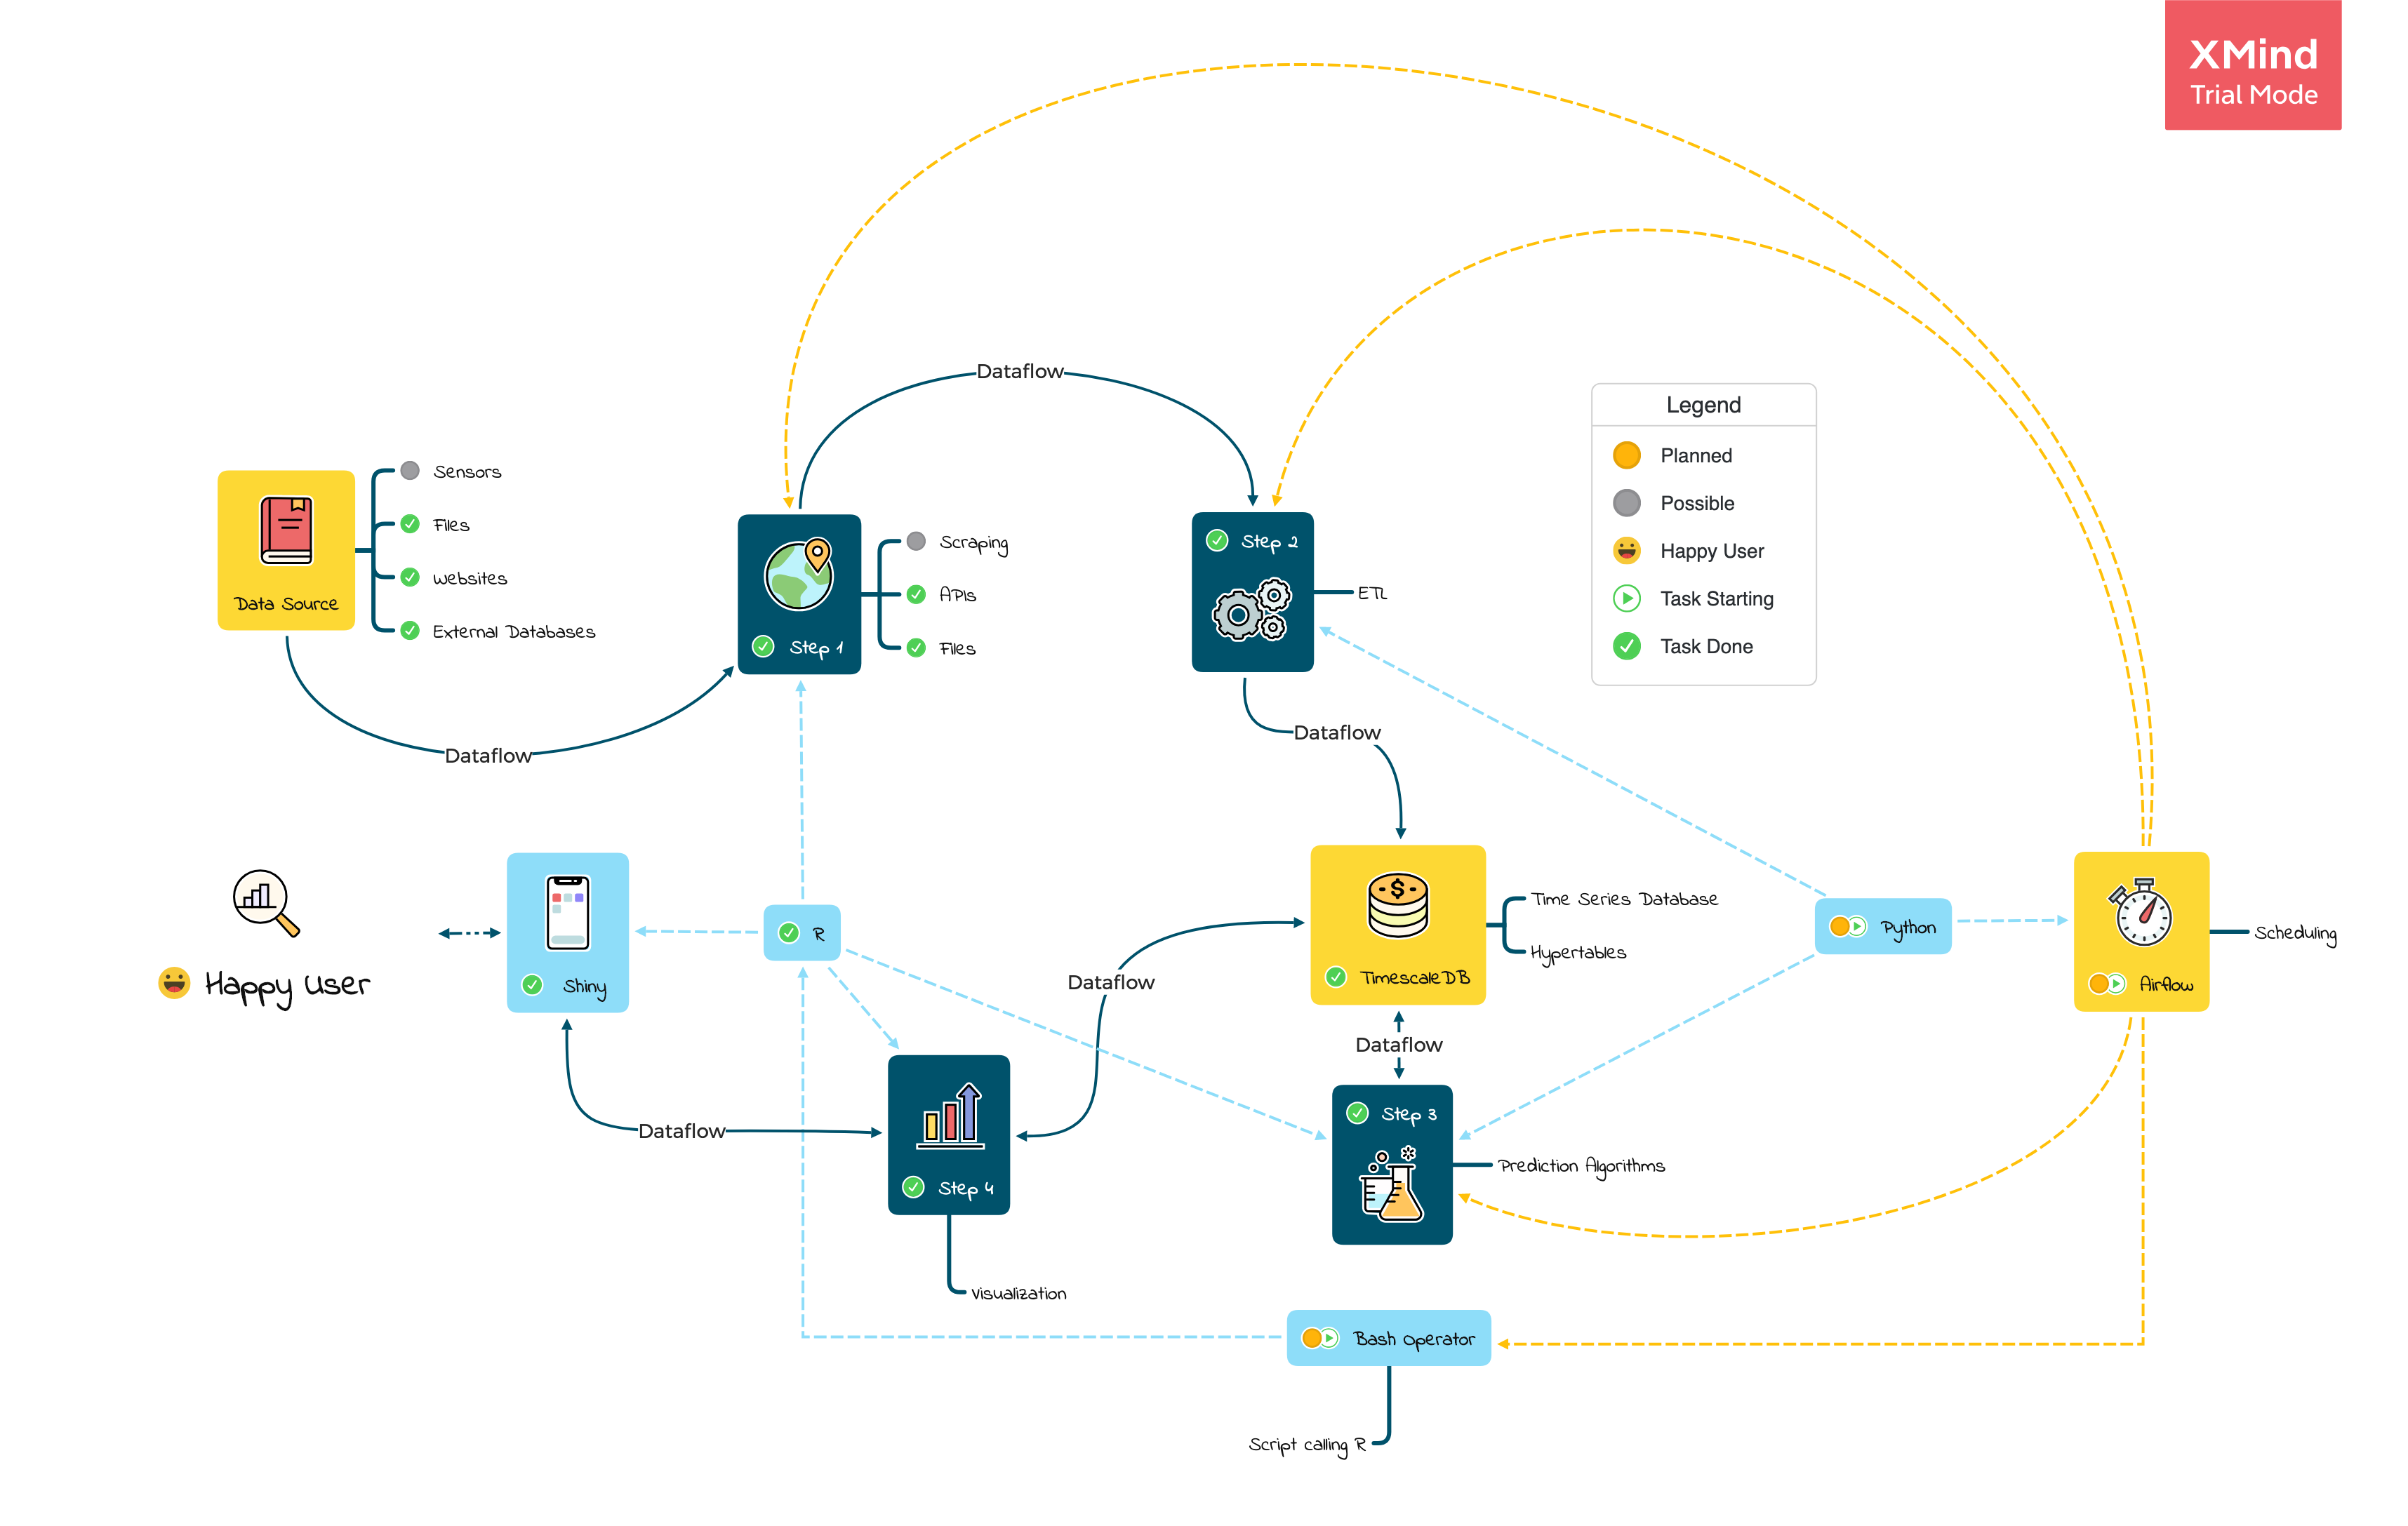

In [114]:
Image(filename="man/Time Series Prediction Infrastructure.png")

I have worked on an extension of this project. The image above gives a basic idea of what would be the next step of this project, using R and Shiny (Data Science Tools).

I will also use coordinates and the timescale-gis extension there for even more insight.

For more details you can find my repo here: https://github.com/AionosChina/Time-Series-Prediction-Infrastructure
